In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

In [2]:
# Set up a function for the comoving distance

def com(z_, OmC, OmB, HH0, Nnu):
    """ Gets the comoving distance in units of Mpc/h at a given redshift, z_ (assuming the cosmology defined in the params file). """
    
    OmR	=	2.47*10**(-5)/(HH0/100.)**2
    OmN	=	Nnu*(7./8.)*(4./11.)**(4./3.)*OmR
    OmL = 1. - OmC - OmB - OmR - OmN
    c=2.99792458*10**(8)
    H0	=	10**(5)/c
    
    def chi_int(z):
        return 1. / (H0 * ( (OmC+OmB)*(1+z)**3 + OmL + (OmR+OmN) * (1+z)**4 )**(0.5))

    if hasattr(z_, "__len__"):
        chi=np.zeros((len(z_)))
        for zi in range(0,len(z_)):
            #print "zi in com=", zi
            chi[zi] = scipy.integrate.quad(chi_int,0,z_[zi])[0]
    else:
        chi = scipy.integrate.quad(chi_int, 0, z_)[0]

    return chi

In [3]:
# Set up the Schechter luminosity function parameters from Krause et al. 2015

z_1 = 0.28; z_2 = 0.77; mlim_1 = 21.8; mlim_2 = 27.; 
Mp = -22.

# Power law function for a_h
#alpha_h = 0.081; beta_h = 2.1

# We are using parameters from Krause et al. 2015, red galaxies
Mr_s = -20.34; Q = 1.8; alpha = -0.57; phi_0 = 1.1 * 10**(-2); P = -1.2

phi_s_1 = phi_0 * 10**(0.4 * P*z_1); print "phi s 1= ", phi_s_1
phi_s_2 = phi_0 * 10**(0.4 * P*z_2); print "phi_s 2= ", phi_s_2

Ms_1 = Mr_s - Q * ( z_1 - 0.1 ); Ms_2 = Mr_s - Q * ( z_2 - 0.1)
Ls_1 = 10.**(-0.4 *(Ms_1-Mp)); Ls_2 = 10.**(-0.4 *(Ms_2-Mp))

print "Ms_1=", Ms_1, "Ls_1=", Ls_1
print "Ms_2=", Ms_2, "Ls_2=", Ls_2


phi s 1=  0.00807221434067
phi_s 2=  0.00469669853453
Ms_1= -20.664 Ls_1= 0.292146037388
Ms_2= -21.546 Ls_2= 0.658263841641


In [4]:
# Import the k correction and EC correction from Poggianti (assuming elliptical galaxies)
# Only data up to z=3 so have just extended at a constant the highest-z value
(z_k, kcorr, x,x,x) = np.loadtxt('../txtfiles/kcorr.dat', unpack=True)
(z_e, ecorr, x,x,x) = np.loadtxt('../txtfiles/ecorr.dat', unpack=True)

kcorr_interp = scipy.interpolate.interp1d(z_k, kcorr)
ecorr_interp = scipy.interpolate.interp1d(z_e, ecorr)

kcorr_1 = kcorr_interp(z_1)
ecorr_1 = ecorr_interp(z_1)
kcorr_2 = kcorr_interp(z_2)
ecorr_2 = ecorr_interp(z_2)

print "kcorr_1=", kcorr_1, "kcorr_2=", kcorr_2
print "ecorr_1=", ecorr_1, "ecorr_2=", ecorr_2

kcorr_1= 0.361 kcorr_2= 1.784625
ecorr_1= -0.322 ecorr_2= -0.975625


In [5]:
# Get the absolute magnitude that corresponds to the limiting apparent magnitude
dl_1 = com(z_1, 0.2, 0.05, 70., 3.046) * (1. + z_1)
dl_2 = com(z_2, 0.2, 0.05, 70., 3.046) * (1. + z_2)

Mlim_1 = mlim_1 - (5. * np.log10(dl_1) + 25. + kcorr_1 + ecorr_1); Llim_1 = 10.**(-0.4 * (Mlim_1-Mp))
print "Mlim 1=", Mlim_1, "Llim 1=", Llim_1
Mlim_2 = mlim_2 - (5. * np.log10(dl_2) + 25. + kcorr_2 + ecorr_2); Llim_2 = 10.**(-0.4 * (Mlim_2-Mp))
print "Mlim 2=", Mlim_2, "Llim 2=", Llim_2

print "ratio of limiting L=", Llim_1 / Llim_2

Mlim 1= -18.2700766514 Llim 1= 0.0322129620199
Mlim 2= -16.4904779577 Llim 2= 0.00625447963925
ratio of limiting L= 5.15038242635


Lavg1= 0.210933840668
Lavg2= 0.333441461695


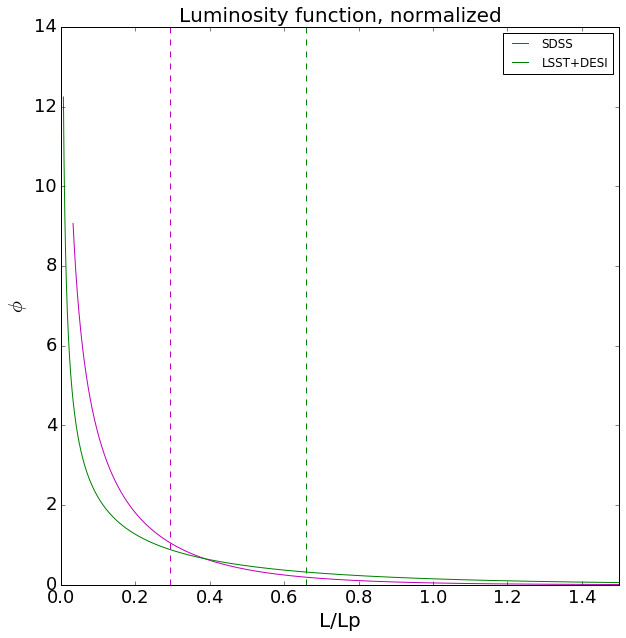

In [6]:
L_1 = scipy.logspace(np.log10(Llim_1), 1, 1000)
L_2 = scipy.logspace(np.log10(Llim_2), 1, 1000)

phi_func_1= phi_s_1 * (L_1 / Ls_1) ** (alpha) * np.exp(- L_1 / Ls_1)
phi_func_2= phi_s_2 * (L_2 / Ls_2) ** (alpha) * np.exp(- L_2 / Ls_2)

norm_1 = scipy.integrate.simps(phi_func_1 * L_1, np.log(L_1))
norm_2 = scipy.integrate.simps(phi_func_2 * L_2, np.log(L_2))

# Average luminosity of each sample:
L_avg_1 = scipy.integrate.simps(phi_func_1 * L_1, L_1) / norm_1
L_avg_2 = scipy.integrate.simps(phi_func_2 * L_2, L_2) / norm_2

print "Lavg1=", L_avg_1
print "Lavg2=", L_avg_2

M_1 = np.log10(L_1) / (-0.4)
M_2 = np.log10(L_2) / (-0.4)

#print "phi_func_1 / norm_1 =", phi_func_1 / norm_1 

plt.figure(figsize=(10,10))
plt.plot(L_1, phi_func_1 / norm_1 , 'm', label='SDSS')
plt.hold(True)
plt.plot(L_2, phi_func_2 / norm_2 , 'g', label='LSST+DESI')
plt.hold(True)
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('L/Lp', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.xlim(0., 1.5)
#plt.ylim(10**(-8),1000)
plt.tick_params(axis='both', labelsize='18')
plt.legend()
plt.title('Luminosity function, normalized', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
#plt.legend()
plt.show()
        

In [ ]:
L0 = 10.**(-0.4 * (-22.))
print "L0=", L0

#a_h = [0]*(len(z))
#for i in range(0, len(z)):
#num = scipy.integrate.simps(phi_func[i, :] * alpha_h * (L_list[i] / L0)**beta_h, L_list[i])
a_h_1 = scipy.integrate.simps(phi_func_1 / norm_1 * alpha_h * (L_1 / L0)**beta_h * L_1, np.log(L_1))
a_h_2 = scipy.integrate.simps(phi_func_2 / norm_2 * alpha_h * (L_2 / L0)**beta_h * L_2, np.log(L_2))

plt.figure(figsize=(10,10))
plt.semilogx(L_1, phi_func_1 / norm_1* alpha_h * (L_1 / L0)**beta_h, 'm', label='SDSS')
plt.hold(True)
plt.semilogx(L_2, phi_func_2 / norm_2* alpha_h * (L_2 / L0)**beta_h, 'g', label='LSST+DESI')
plt.xlabel("Luminosity (arbitrary units)", fontsize=20)
plt.ylabel("$a_h(L) \phi(L)$", fontsize=20)
plt.tick_params(axis='both', labelsize='18')
plt.savefig('../plots/Lum_func_times_ah.pdf')
plt.legend()
plt.show()

print "ah 1=", a_h_1, "ah 2=", a_h_2

In [ ]:
# Get the normalized redshift distribution in terms of spec z
#dNdz = get_NofZ([1.24, 0.51, 1.01], 'Smail', z)
#dNdz = get_NofZ([2.338, 0.303], 'Nakajima', z)

# and integrate over it

#a_h_intz = scipy.integrate.simps(a_h*dNdz, z)
print "A=", a_h